# Impor pustaka yang diperlukan

In [ ]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Input, Model

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/MyDrive/chest_xray_v3/train'
test_dir = '/content/drive/MyDrive/chest_xray_v2/test'
val_dir = '/content/drive/MyDrive/chest_xray_v3/val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pneumonia_train_images = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_dir+"/NORMAL/*.jpeg")

# Visualisasi Data

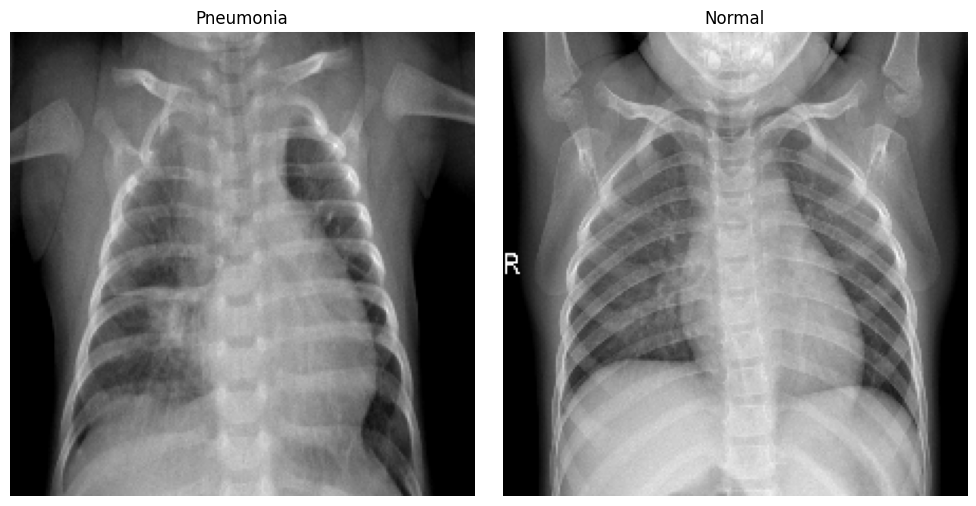

In [ ]:
import random

# Mengambil gambar acak dari masing-masing kelas
pneumonia_image = random.choice(pneumonia_train_images)  # Mengambil gambar acak dari pneumonia_train_images
normal_image = random.choice(normal_train_images)  # Mengambil gambar acak dari normal_train_images

# Menampilkan gambar Pneumonia dan Normal dalam satu baris
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 baris, 2 kolom
# Gambar Pneumonia
img_pneumonia = cv2.imread(pneumonia_image)
img_pneumonia = cv2.resize(img_pneumonia, (220, 220))
axes[0].imshow(cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2RGB))  # Mengkonversi warna BGR ke RGB
axes[0].set_title("Pneumonia")
axes[0].axis('off')  # Menonaktifkan axis

# Gambar Normal
img_normal = cv2.imread(normal_image)
img_normal = cv2.resize(img_normal, (220, 220))
axes[1].imshow(cv2.cvtColor(img_normal, cv2.COLOR_BGR2RGB))  # Mengkonversi warna BGR ke RGB
axes[1].set_title("Normal")
axes[1].axis('off')  # Menonaktifkan axis

plt.tight_layout()  # Mengatur jarak antar subplots
plt.show()

# Deteksi tepi Canny

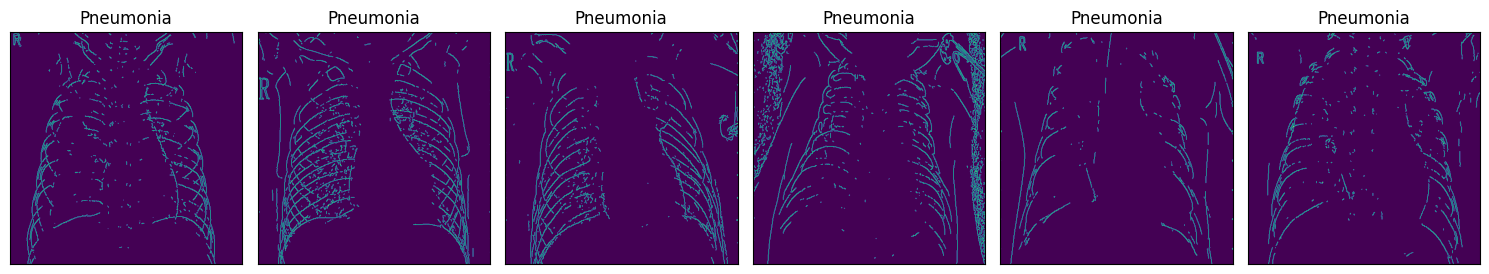

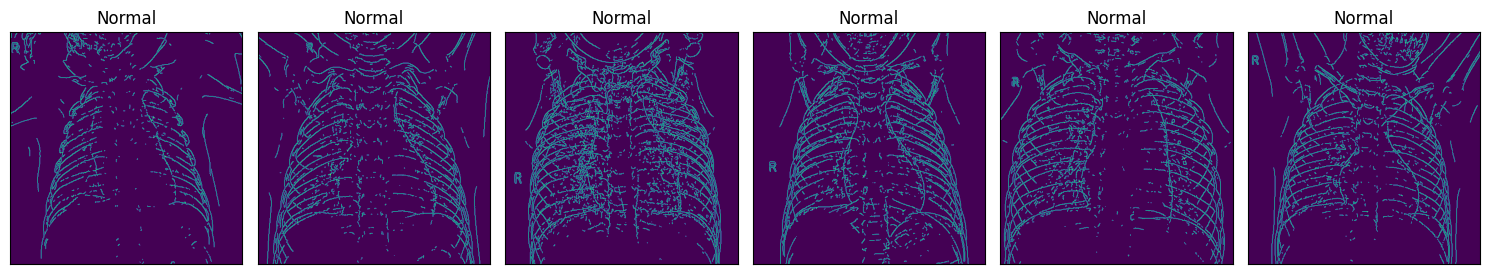

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()
plt.show()

# Membuat generator data gambar

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Rotasi acak
    width_shift_range=0.2,      # Pergeseran horizontal
    height_shift_range=0.2,     # Pergeseran vertikal
    shear_range=0.15,           # Distorsi geser
    zoom_range=0.2,             # Pembesaran acak
    horizontal_flip=True        # Membalik gambar
)
val_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=32, class_mode='binary', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=32, class_mode = 'binary', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir,shuffle=False, batch_size=32, class_mode = 'binary', target_size=(224, 224))

Found 4189 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
input_shape = (224, 224, 3)

# Model Development

In [ ]:
# Load base model dengan ResNet50V2 tanpa top layer, menggunakan weights imagenet
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)
base_model.trainable = True

# Freeze semua layer kecuali 20 layer terakhir
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Build model menggunakan Functional API
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x) # Pooling layer
x = Dense(256, activation='relu')(x)  # Menambah unit Dense
x = Dropout(0.3)(x)  # Dropout layer untuk regularisasi
outputs = Dense(1, activation='sigmoid')(x) # Output layer

model = tf.keras.Model(inputs, outputs)

# Tampilkan jumlah parameter dalam model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 8,404,481 (32.06 MB)

 Non-trainable params: 15,685,120 (59.83 MB)

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback untuk menurunkan learning rate ketika val_loss tidak meningkat
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Training model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[lr_scheduler]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 1641s 12s/step - accuracy: 0.9117 - loss: 0.2548 - val_accuracy: 0.9463 - val_loss: 0.3446 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 130s 897ms/step - accuracy: 0.9562 - loss: 0.1356 - val_accuracy: 0.9166 - val_loss: 0.4395 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 923ms/step - accuracy: 0.9560 - loss: 0.1152 - val_accuracy: 0.9386 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9579 - loss: 0.1193 - val_accuracy: 0.9492 - val_loss: 0.1766 - learning_rate: 0.0010
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 181s 905ms/step - accuracy: 0.9591 - loss: 0.1307 - val_accuracy: 0.9291 - val_loss: 0.2067 - learning_rate: 0.0010
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9643 - loss: 0.0949 - val_accuracy: 0.9645 - val_loss: 0.0882 - learning_rate: 0.0010
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 904ms/step - accuracy: 0.9603 - loss:

# Save The Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/SaveModel/model_Resnet50V2_80:20.keras")  # ganti MyDrive dengan path sesuai lokasi penyimpanan


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model metrics

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualisasi training dan validation accuracy dan loss


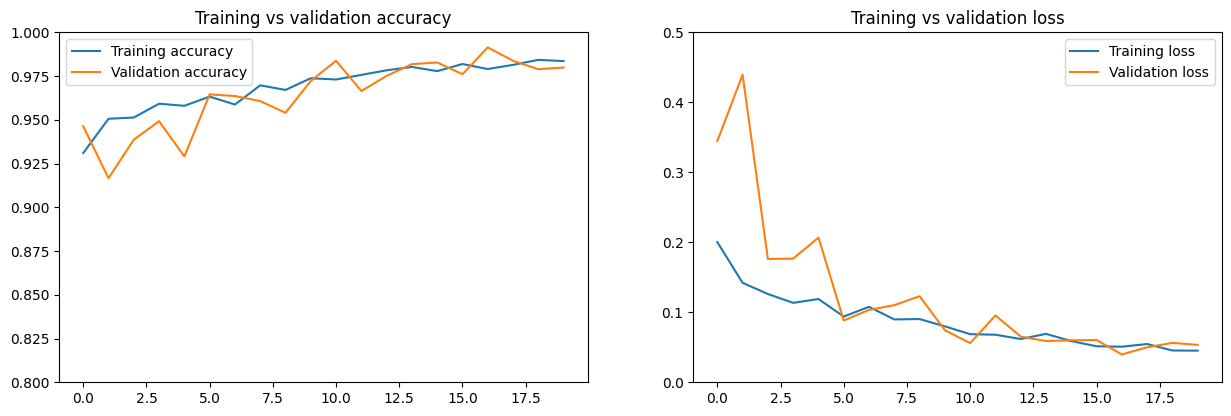

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.ylim(0.8, 1)
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.ylim(0, 0.5)
plt.legend()
plt.title("Training vs validation loss")

plt.show()

# Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import load_model
from tensorflow.keras.models import load_model

# Load model dari Google Drive
model = load_model("/content/drive/MyDrive/SaveModel/model_Resnet50V2_80:20.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.9693 - loss: 0.1638
Test Loss: 0.130336195230484
Test Accuracy: 0.9700000286102295


# Predictions

In [ ]:
pred = model.predict(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step


In [ ]:
pred

array([[1.5644685e-03],
       [9.8321107e-06],
       [9.9884148e-04],
       [2.0484331e-03],
       [3.5407131e-03],
       [2.9370682e-02],
       [7.3438779e-02],
       [2.2526296e-05],
       [7.2697876e-03],
       [1.4869195e-04],
       [5.4123539e-05],
       [7.1801781e-03],
       [2.3312430e-04],
       [1.5922835e-01],
       [7.2086346e-05],
       [5.6460271e-06],
       [1.7539882e-03],
       [3.5513667e-04],
       [1.5376016e-03],
       [5.2052003e-04],
       [9.9891114e-01],
       [6.3565845e-04],
       [5.0746021e-04],
       [7.4951364e-05],
       [3.3388367e-01],
       [1.8081680e-01],
       [3.2995683e-03],
       [1.7393228e-01],
       [3.9154805e-02],
       [7.9984160e-04],
       [3.1427655e-02],
       [3.2352153e-02],
       [1.8349427e-04],
       [3.6822227e-03],
       [4.2442899e-04],
       [7.1863132e-03],
       [4.6290347e-01],
       [1.2231558e-02],
       [1.0500068e-01],
       [5.0753467e-03],
       [2.1827182e-02],
       [3.208122

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
y_true = test_generator.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Confusion matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)

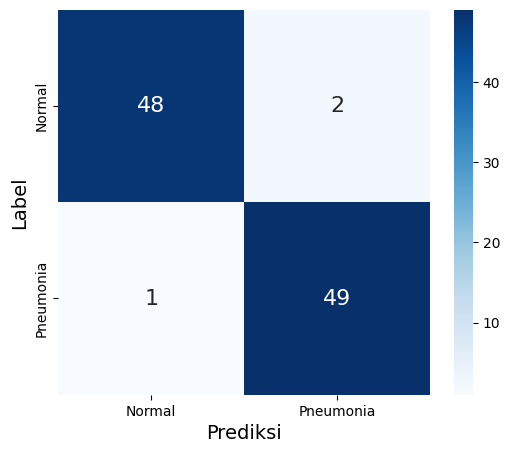

In [ ]:
labels = ['Normal', 'Pneumonia']

# Membuat heatmap dengan label yang disesuaikan
plt.figure(figsize=(6, 5))
sn.heatmap(cm, annot=True, cmap="Blues", fmt='g', annot_kws={"size": 16},
            xticklabels=labels, yticklabels=labels)

# Menambahkan label pada sumbu x dan y
plt.xlabel('Prediksi', fontsize=14)
plt.ylabel('Label', fontsize=14)

# Menampilkan plot
plt.show()

# Classification report

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        50
           1       0.96      0.98      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

